In [1]:
import time

# torch
import torch
import torch.nn as nn
import torch.optim as optim

# jax
import jax
import jax.numpy as jnp
import flax.linen as fnn
from flax.training import train_state
import optax

# dataset
import tensorflow_datasets as tfds
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)

In [2]:
# Dataloader (common)

def preprocessing(x):
    x = tf.cast(x["image"], tf.float32) / 255.
    return x

ds = tfds.load("mnist", as_supervised=False, shuffle_files=False, download=True)
train_set = ds["train"]
train_set = train_set.shuffle(len(train_set), seed=0, reshuffle_each_iteration=True).batch(32).map(preprocessing).prefetch(1)
val_set = ds["test"]
val_set = val_set.batch(32).map(preprocessing).prefetch(1)

In [3]:
# jax

class Encoder(fnn.Module):
    @fnn.compact
    def __call__(self, x):
        x = fnn.Dense(400)(x.reshape(-1, 784))
        x = fnn.relu(x)
        mu = fnn.Dense(20)(x)
        logvar = fnn.Dense(20)(x)
        
        return mu, logvar

class Decoder(fnn.Module):
    @fnn.compact
    def __call__(self, x):
        x = fnn.Dense(400)(x)
        x = fnn.relu(x)
        x = fnn.Dense(784)(x)
        recon_x = x.reshape(-1, 28, 28, 1)
        return recon_x

class VAE(fnn.Module):
    
    @fnn.compact
    def __call__(self, x, z_rng):
        mu, logvar = Encoder()(x)
        z = self.reparameterize(z_rng, mu, logvar)
        recon_x = Decoder()(z)
        
        return recon_x, mu, logvar
        
    def reparameterize(self, rng, mu, logvar):
        std = jnp.exp(0.5 * logvar)
        eps = jax.random.normal(rng, logvar.shape)
        return mu + eps * std 
    
key = jax.random.PRNGKey(0)
rng1, key = jax.random.split(key)
rng2, key = jax.random.split(key)

model = VAE()
params = model.init(rng1, jnp.ones([1, 28, 28, 1]), rng2)['params']
tx = optax.adam(0.001)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

def loss_function(x, recon_x, mu, logvar):
    KLD = -0.5 * jnp.sum(1 + logvar - jnp.square(mu) - jnp.exp(logvar))
    # inside the optax.sigmoid_bce, the recon_x is first fed to nn.logsigmoid
    # https://github.com/deepmind/optax/blob/master/optax/_src/loss.py#L116#L138
    BCE = optax.sigmoid_binary_cross_entropy(recon_x, x).sum()
    return BCE + KLD

@jax.jit
def train_step(state, batch, z_rng):
    x = jnp.array(batch)
    def loss_fn(params):
        recon_x, mu, logvar = state.apply_fn({'params': params}, x, z_rng)
        loss = loss_function(x, recon_x, mu, logvar)
        return loss, recon_x
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, recon_x), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    
    return loss, recon_x, state

for e in range(5):
    tic = time.time()
    train_loss = 0
    for batch in train_set.as_numpy_iterator():
        z_rng, key = jax.random.split(key)
        loss, recon_x, state = train_step(state, batch, z_rng)
        train_loss += loss
    train_loss /= len(train_set)
    elapsed = time.time() - tic
    print(f"epoch: {e} | train_loss: {train_loss:0.2f}, elapsed: {elapsed:0.2f}")

epoch: 0 | train_loss: 4198.54, elapsed: 6.11
epoch: 1 | train_loss: 3628.01, elapsed: 2.74
epoch: 2 | train_loss: 3542.19, elapsed: 2.87
epoch: 3 | train_loss: 3497.75, elapsed: 2.85
epoch: 4 | train_loss: 3468.73, elapsed: 2.82


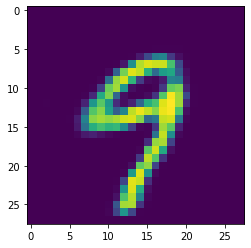

In [4]:
plt.imshow(fnn.sigmoid(recon_x[0]))

In [5]:

device = "cuda:1" if torch.cuda.is_available() else "cpu"

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z).reshape(len(x), 1, 28, 28)
        return recon_x, mu, logvar
    
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.BCELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return  KLD + BCE

model = VAE().to(device)
opt = optim.Adam(model.parameters(), lr=0.001)

def train_step(model, batch):
    x = torch.from_numpy(batch).to(device).permute(0, 3, 1, 2)
    recon_x, mu, logvar = model(x)
    loss = loss_function(recon_x, x, mu, logvar)
    opt.zero_grad()
    loss.backward()
    opt.step()
    return loss, recon_x
    
for e in range(5):
    tic = time.time()
    train_loss = 0
    for batch in train_set.as_numpy_iterator():
        loss, recon_x = train_step(model, batch)
        train_loss += loss
    train_loss /= len(train_set)
    elapsed = time.time() - tic
    print(f"epoch: {e} | train_loss: {train_loss:0.2f}, elapsed: {elapsed:0.2f}")

/tmp/ipykernel_11593/1474508580.py:41: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  x = torch.from_numpy(batch).to(device).permute(0, 3, 1, 2)


epoch: 0 | train_loss: 4388.47, elapsed: 6.48
epoch: 1 | train_loss: 3629.27, elapsed: 6.35
epoch: 2 | train_loss: 3526.95, elapsed: 6.49
epoch: 3 | train_loss: 3480.09, elapsed: 6.44
epoch: 4 | train_loss: 3450.51, elapsed: 6.59


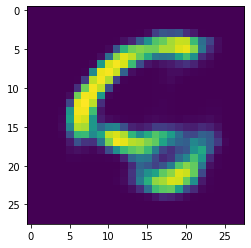

In [6]:
plt.imshow(recon_x[0].reshape(28, 28).detach().cpu())